## Pandas analysis

This exercise consists in analyzing a dataset containg timing information from a series of Time-to-Digital-Converters (TDC) implemented in a couple of FPGAs. Each measurement (i.e. each row of the input file) consists of a flag that specifies the type of message ('HEAD', which in this case is always 1), two addresses of the TDC providing the signal ('FPGA' and 'TDC_CHANNEL'), and the timing information ('ORBIT_CNT', 'BX_COUNTER', and 'TDC_MEAS'). Each TDC count corresponds to 25/30 ns, whereas a unit of BX_COUNTER corresponds to 25 ns, and the ORBIT_CNT is increased every 'x' BX_COUNTER. This allows to store the time in a similar way to hours, minutes and seconds.

In [ ]:
# If you didn't download it yet, please get the relevant file now!
!wget https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt -P ~/data/

1\. Create a Pandas DataFrame reading N rows of the 'data_000637.txt' dataset. Choose N to be smaller than or equal to the maximum number of rows and larger that 10k.

2\. Find out the number of BX in a ORBIT (the value 'x').

3\. Find out how much the data taking lasted. You can either make an estimate based on the fraction of the measurements (rows) you read, or perform this check precisely by reading out the whole dataset.

4\. Create a new column with the absolute time in ns (as a combination of the other three columns with timing information).

5\. Replace the values (all 1) of the HEAD column randomly with 0 or 1.

6\. Create a new DataFrame that contains only the rows with HEAD=1.

7\. Make two occupancy plots (one for each FPGA), i.e. plot the number of counts per TDC channel

8\. Use the groupby method to find out the noisy channels, i.e. the TDC channels with most counts (say the top 3)

9\. Count the number of unique orbits. Count the number of unique orbits with at least one measurement from TDC_CHANNEL=139

1\. Create a Pandas DataFrame reading N rows of the 'data_000637.txt' dataset. Choose N to be smaller than or equal to the maximum number of rows and larger that 10k.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
N = 20000
totN = 1310721

data = pd.read_csv("data/data_000637.txt", nrows= N)
data

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS
0,1,0,123,3869200167,2374,26
1,1,0,124,3869200167,2374,27
2,1,0,63,3869200167,2553,28
3,1,0,64,3869200167,2558,19
4,1,0,64,3869200167,2760,25
...,...,...,...,...,...,...
19995,1,0,27,3869200366,2513,29
19996,1,0,63,3869200366,2517,6
19997,1,0,32,3869200366,2519,5
19998,1,0,17,3869200366,2522,21


2\. Find out the number of BX in a ORBIT (the value 'x').

In [4]:

print(f"there are {data['BX_COUNTER'].max()} BX in a Orbit")

there are 3563 BX in a Orbit


3\. Find out how much the data taking lasted. You can either make an estimate based on the fraction of the measurements (rows) you read, or perform this check precisely by reading out the whole dataset.

In [139]:
meas4bx = data['TDC_MEAS'].max()
bx4orbit = data['BX_COUNTER'].max()
print(meas4bx,' ', bx4orbit)

#in nanoseconds
t_meas = 25/30 

#considering my 20000 rows
n_orbit = data['ORBIT_CNT'].max() - data['ORBIT_CNT'].min()

print(n_orbit)

tail = data[data['ORBIT_CNT'] == data['ORBIT_CNT'].max()]
tail_bx = tail.iloc[-1,4]
tail_meas = tail[tail['BX_COUNTER'] == tail['BX_COUNTER'].max()].iloc[-1,5]

time = ((n_orbit) * bx4orbit * meas4bx + tail_bx * meas4bx + tail_meas) * t_meas
print(f"the total duration for {N} measures is {time}ns")

#N/totN = time/tot_time
tot_time = totN * time / N
print(f"the estimated duration for al the measure is {tot_time}ns")

29   3563
199
the total duration for 20000 measures is 17196009.166666668ns
the estimated duration for al the measure is 1126958516.547125ns


4\. Create a new column with the absolute time in ns (as a combination of the other three columns with timing information).

In [81]:
init_orbit = data['ORBIT_CNT'].min()

# here i consider the time to start at 0 with the actual first orbit
data2 = data.copy()
data2['time_ns']=((data['ORBIT_CNT']-init_orbit)* bx4orbit * meas4bx + 
                 data['BX_COUNTER']* meas4bx + data['TDC_MEAS']) * t_meas
data2

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,time_ns
0,1,0,123,3869200167,2374,26,5.739333e+04
1,1,0,124,3869200167,2374,27,5.739417e+04
2,1,0,63,3869200167,2553,28,6.172083e+04
3,1,0,64,3869200167,2558,19,6.183417e+04
4,1,0,64,3869200167,2760,25,6.672083e+04
...,...,...,...,...,...,...,...
19995,1,0,27,3869200366,2513,29,1.719582e+07
19996,1,0,63,3869200366,2517,6,1.719589e+07
19997,1,0,32,3869200366,2519,5,1.719594e+07
19998,1,0,17,3869200366,2522,21,1.719603e+07


5\. Replace the values (all 1) of the HEAD column randomly with 0 or 1.

In [86]:
#make the random column as a np array
rand_head = np.random.random(size=(len(data2),1))
rand_head[rand_head > 0.5] = 1
rand_head[rand_head <= 0.5] = 0

#push the new column
data2['HEAD'] = list(rand_head)
#convert to integer
data2['HEAD'] = data2['HEAD'].apply(lambda x: int(x))

data2

[[0.]
 [0.]
 [1.]
 ...
 [1.]
 [1.]
 [0.]]


,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,time_ns
0,0,0,123,3869200167,2374,26,5.739333e+04
1,0,0,124,3869200167,2374,27,5.739417e+04
2,1,0,63,3869200167,2553,28,6.172083e+04
3,1,0,64,3869200167,2558,19,6.183417e+04
4,1,0,64,3869200167,2760,25,6.672083e+04
...,...,...,...,...,...,...,...
19995,0,0,27,3869200366,2513,29,1.719582e+07
19996,1,0,63,3869200366,2517,6,1.719589e+07
19997,1,0,32,3869200366,2519,5,1.719594e+07
19998,1,0,17,3869200366,2522,21,1.719603e+07


6\. Create a new DataFrame that contains only the rows with HEAD=1.

In [93]:
data_h1 = data2[data2['HEAD'] == 1]
data_h1

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,time_ns
2,1,0,63,3869200167,2553,28,6.172083e+04
3,1,0,64,3869200167,2558,19,6.183417e+04
4,1,0,64,3869200167,2760,25,6.672083e+04
9,1,0,60,3869200167,2788,7,6.738250e+04
12,1,1,6,3869200167,2792,18,6.748833e+04
...,...,...,...,...,...,...,...
19992,1,0,40,3869200366,2388,28,1.719279e+07
19993,1,0,42,3869200366,2392,22,1.719289e+07
19996,1,0,63,3869200366,2517,6,1.719589e+07
19997,1,0,32,3869200366,2519,5,1.719594e+07


7\. Make two occupancy plots (one for each FPGA), i.e. plot the number of counts per TDC channel

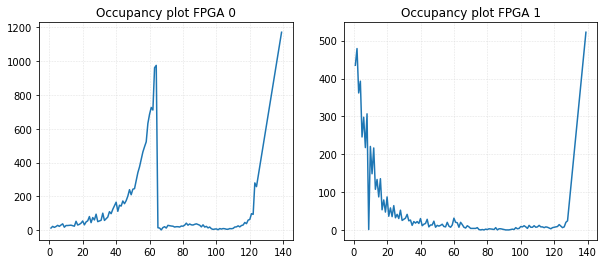

In [17]:

data_chan = data.groupby('ORBIT_CNT').sum()
data_f0 = data[data['FPGA']==0]
data_f1 = data[data['FPGA']==1]
data_f0s = data_f0.groupby('TDC_CHANNEL').sum()
data_f1s = data_f1.groupby('TDC_CHANNEL').sum()


fig, ax = plt.subplots(1, 2, figsize=(10,4))

ax[0].plot(data_f0s['HEAD'])
ax[0].set_title("Occupancy plot FPGA 0")
ax[0].grid(color='lightgrey', linestyle=':', linewidth=0.6)

ax[1].plot(data_f1s['HEAD'])
ax[1].set_title("Occupancy plot FPGA 1")
ax[1].grid(color='lightgrey', linestyle=':', linewidth=0.6)


8\. Use the groupby method to find out the noisy channels, i.e. the TDC channels with most counts (say the top 3)

In [15]:
data_chan = data.groupby('TDC_CHANNEL').sum()
data_chan.sort_values(by='HEAD')
noisy_chan = data_chan.iloc[0:3,:]
noisy_chan


,HEAD,FPGA,ORBIT_CNT,BX_COUNTER,TDC_MEAS
TDC_CHANNEL,,,,,
1,448,435,1733401718409,864488,6431
2,502,479,1942338533552,959766,7390
3,379,362,1466426900120,653577,5448


9\. Count the number of unique orbits. Count the number of unique orbits with at least one measurement from TDC_CHANNEL=139

In [16]:

n_orbit = data.groupby("ORBIT_CNT").nunique()
print(f"there are {len(n_orbit)} unique orbits")

data_filt = data[data['TDC_CHANNEL']==139]
n_filt_orbit = len(data_filt.groupby('ORBIT_CNT').nunique())

print(f"there are {n_filt_orbit} orbit with a measure from channel 139")



there are 200 unique orbits
there are 200 orbit with a measure from channel 139
